# Wine aroma prediction using ResNet 
Here will be used ResNet to predict wine aroma from the previously obtained wine composition matrices

In [19]:
#Import the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split, KFold

import torchvision as tv
import os
import numpy as np
import matplotlib.pyplot as plt

from tqdm.autonotebook import tqdm
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import average_precision_score
import seaborn as sns
import pandas as pd
from torchvision.transforms import functional as TF

## 1. Working with data
At this stage, load the previously prepared data, and process the data for further neural networking 

In [2]:
# Loading data
X_array =  np.load('X_array.npy')
Y_array =  np.load('Y_array.npy')

In [3]:
# Separation of data into training, validation and test data in the ratio of 70:20:10
X_train, X_test, y_train, y_test = train_test_split(X_array, Y_array, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [4]:
# Conversion to a tensor
X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train)
X_val = torch.tensor(X_val)
y_val = torch.tensor(y_val)
X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test)

In [5]:
print(len(X_train))
print(len(y_train))
print(len(X_val))
print(len(y_val))
print(len(X_test))
print(len(y_test))

323
323
81
81
45
45


Since ResNet has been trained on 224x224 images, needs to bring images to the same size by padding (adding white pixels in equal proportions to the bottom, top and sides of the image), a method chosen to preserve chemical information without distorting it through interpolation

In [6]:
# Create a custom dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        # Add channels if there are none (i.e. if the images have dimension [N, H, W]).
        if x.dim() == 3:  
            x = x.unsqueeze(1)  # add channel dimensionality [N, 1, H, W]

        self.x = self.pad_to_224(x)  # Adding padding
        self.y = y

    def pad_to_224(self, x):
        padded_images = []
        for img in x:
            # check that the input images are of size [1, 44, 100]
            _, h, w = img.shape
            assert h == 44 and w == 100, "Incorrect size of the input image"

            # Applying padding
            img_padded = TF.pad(img, (62, 90), fill=255)  # White background

            padded_images.append(img_padded)

        return torch.stack(padded_images)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# Create Dataset and DataLoader
dataset_train = CustomDataset(X_train, y_train)
dataset_val = CustomDataset(X_val, y_val)
dataset_test = CustomDataset(X_test, y_test)

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=32, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=False)


In [7]:
for x, y in dataloader_train:
    print(x.size())

torch.Size([32, 1, 224, 224])
torch.Size([32, 1, 224, 224])
torch.Size([32, 1, 224, 224])
torch.Size([32, 1, 224, 224])
torch.Size([32, 1, 224, 224])
torch.Size([32, 1, 224, 224])
torch.Size([32, 1, 224, 224])
torch.Size([32, 1, 224, 224])
torch.Size([32, 1, 224, 224])
torch.Size([32, 1, 224, 224])
torch.Size([3, 1, 224, 224])


## 3. Loading of the pre-trained model and its additional training
At this stage  will loaded the pre-trained model, change the necessary parameters, and retrain it on data

In [8]:
# Loading a pre-trained model
model_resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model_resnet.eval()

Using cache found in C:\Users\Peach/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\Peach\anaconda3\envs\practicum\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Peach\anaconda3\envs\practicum\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
# Replace the last full-link layer with a new layer that will match dataset
num_classes = 10  
model_resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_resnet.fc = nn.Linear(in_features=512, out_features=num_classes, bias=True)
model_resnet

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
# Definition of loss-function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_resnet.parameters(), lr=0.0001, betas=(0.9, 0.999))


In [9]:
# Accuracy function
def accuracy(pred, label, threshold=0.5):
    pred = torch.sigmoid(pred)
    pred_labels = (pred > threshold).float()  # Threshold the predictions
    correct = (pred_labels == label).sum().item()  # Compare predictions with labels
    total = label.size(0) * label.size(1)  # Total number of labels
    return correct / total

In [10]:
# Transferring the neural network to cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
# Model retraining
num_epochs = 100 

for epoch in range(num_epochs):
    running_loss = 0.0
    acc_val = 0.0
    
    for matrix, labels in tqdm(dataloader_train, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
        # Convert the data to the required format (float32) and move it to the device
        matrix, labels = matrix.float().to(device), labels.to(device)

        optimizer.zero_grad()
        
        outputs = model_resnet(matrix)

        # Calculate the error
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # Accuracy 
        acc_current = accuracy(outputs.cpu().float(), labels.cpu().float())
        acc_val += acc_current

    # Output the average loss and accuracy over the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader_train):.3f}, Accuracy: {acc_val/len(dataloader_train):.3f}")

Epoch 1/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [1/100], Loss: 1.371, Accuracy: 0.701


Epoch 2/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [2/100], Loss: 0.495, Accuracy: 0.768


Epoch 3/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [3/100], Loss: 0.475, Accuracy: 0.777


Epoch 4/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [4/100], Loss: 0.469, Accuracy: 0.780


Epoch 5/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [5/100], Loss: 0.481, Accuracy: 0.764


Epoch 6/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [6/100], Loss: 0.480, Accuracy: 0.774


Epoch 7/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [7/100], Loss: 0.467, Accuracy: 0.775


Epoch 8/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [8/100], Loss: 0.474, Accuracy: 0.769


Epoch 9/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [9/100], Loss: 0.490, Accuracy: 0.769


Epoch 10/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [10/100], Loss: 0.476, Accuracy: 0.774


Epoch 11/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [11/100], Loss: 0.467, Accuracy: 0.780


Epoch 12/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [12/100], Loss: 0.481, Accuracy: 0.774


Epoch 13/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [13/100], Loss: 0.481, Accuracy: 0.766


Epoch 14/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [14/100], Loss: 0.476, Accuracy: 0.769


Epoch 15/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [15/100], Loss: 0.473, Accuracy: 0.768


Epoch 16/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [16/100], Loss: 0.482, Accuracy: 0.770


Epoch 17/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [17/100], Loss: 0.481, Accuracy: 0.769


Epoch 18/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [18/100], Loss: 0.474, Accuracy: 0.775


Epoch 19/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [19/100], Loss: 0.479, Accuracy: 0.770


Epoch 20/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [20/100], Loss: 0.478, Accuracy: 0.770


Epoch 21/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [21/100], Loss: 0.486, Accuracy: 0.767


Epoch 22/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [22/100], Loss: 0.470, Accuracy: 0.770


Epoch 23/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [23/100], Loss: 0.468, Accuracy: 0.785


Epoch 24/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [24/100], Loss: 0.461, Accuracy: 0.786


Epoch 25/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [25/100], Loss: 0.482, Accuracy: 0.777


Epoch 26/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [26/100], Loss: 0.467, Accuracy: 0.781


Epoch 27/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [27/100], Loss: 0.460, Accuracy: 0.785


Epoch 28/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [28/100], Loss: 0.472, Accuracy: 0.776


Epoch 29/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [29/100], Loss: 0.477, Accuracy: 0.772


Epoch 30/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [30/100], Loss: 0.466, Accuracy: 0.780


Epoch 31/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [31/100], Loss: 0.485, Accuracy: 0.783


Epoch 32/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [32/100], Loss: 0.481, Accuracy: 0.774


Epoch 33/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [33/100], Loss: 0.465, Accuracy: 0.780


Epoch 34/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [34/100], Loss: 0.481, Accuracy: 0.772


Epoch 35/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [35/100], Loss: 0.470, Accuracy: 0.781


Epoch 36/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [36/100], Loss: 0.466, Accuracy: 0.783


Epoch 37/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [37/100], Loss: 0.478, Accuracy: 0.777


Epoch 38/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [38/100], Loss: 0.459, Accuracy: 0.788


Epoch 39/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [39/100], Loss: 0.476, Accuracy: 0.772


Epoch 40/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [40/100], Loss: 0.464, Accuracy: 0.774


Epoch 41/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [41/100], Loss: 0.470, Accuracy: 0.779


Epoch 42/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [42/100], Loss: 0.473, Accuracy: 0.780


Epoch 43/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [43/100], Loss: 0.458, Accuracy: 0.791


Epoch 44/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [44/100], Loss: 0.468, Accuracy: 0.788


Epoch 45/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [45/100], Loss: 0.472, Accuracy: 0.772


Epoch 46/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [46/100], Loss: 0.493, Accuracy: 0.766


Epoch 47/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [47/100], Loss: 0.476, Accuracy: 0.774


Epoch 48/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [48/100], Loss: 0.466, Accuracy: 0.782


Epoch 49/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [49/100], Loss: 0.478, Accuracy: 0.774


Epoch 50/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [50/100], Loss: 0.478, Accuracy: 0.776


Epoch 51/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [51/100], Loss: 0.462, Accuracy: 0.785


Epoch 52/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [52/100], Loss: 0.467, Accuracy: 0.788


Epoch 53/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [53/100], Loss: 0.475, Accuracy: 0.777


Epoch 54/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [54/100], Loss: 0.461, Accuracy: 0.776


Epoch 55/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [55/100], Loss: 0.468, Accuracy: 0.774


Epoch 56/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [56/100], Loss: 0.466, Accuracy: 0.780


Epoch 57/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [57/100], Loss: 0.489, Accuracy: 0.771


Epoch 58/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [58/100], Loss: 0.472, Accuracy: 0.772


Epoch 59/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [59/100], Loss: 0.484, Accuracy: 0.773


Epoch 60/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [60/100], Loss: 0.498, Accuracy: 0.760


Epoch 61/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [61/100], Loss: 0.471, Accuracy: 0.775


Epoch 62/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [62/100], Loss: 0.472, Accuracy: 0.783


Epoch 63/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [63/100], Loss: 0.486, Accuracy: 0.772


Epoch 64/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [64/100], Loss: 0.469, Accuracy: 0.777


Epoch 65/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [65/100], Loss: 0.463, Accuracy: 0.780


Epoch 66/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [66/100], Loss: 0.463, Accuracy: 0.786


Epoch 67/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [67/100], Loss: 0.489, Accuracy: 0.764


Epoch 68/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [68/100], Loss: 0.465, Accuracy: 0.783


Epoch 69/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [69/100], Loss: 0.477, Accuracy: 0.773


Epoch 70/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [70/100], Loss: 0.475, Accuracy: 0.777


Epoch 71/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [71/100], Loss: 0.480, Accuracy: 0.772


Epoch 72/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [72/100], Loss: 0.468, Accuracy: 0.771


Epoch 73/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [73/100], Loss: 0.464, Accuracy: 0.785


Epoch 74/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [74/100], Loss: 0.478, Accuracy: 0.769


Epoch 75/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [75/100], Loss: 0.464, Accuracy: 0.785


Epoch 76/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [76/100], Loss: 0.474, Accuracy: 0.772


Epoch 77/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [77/100], Loss: 0.467, Accuracy: 0.774


Epoch 78/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [78/100], Loss: 0.475, Accuracy: 0.785


Epoch 79/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [79/100], Loss: 0.487, Accuracy: 0.766


Epoch 80/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [80/100], Loss: 0.472, Accuracy: 0.780


Epoch 81/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [81/100], Loss: 0.477, Accuracy: 0.772


Epoch 82/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [82/100], Loss: 0.471, Accuracy: 0.778


Epoch 83/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [83/100], Loss: 0.480, Accuracy: 0.774


Epoch 84/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [84/100], Loss: 0.476, Accuracy: 0.777


Epoch 85/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [85/100], Loss: 0.463, Accuracy: 0.783


Epoch 86/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [86/100], Loss: 0.473, Accuracy: 0.772


Epoch 87/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [87/100], Loss: 0.482, Accuracy: 0.766


Epoch 88/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [88/100], Loss: 0.466, Accuracy: 0.778


Epoch 89/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [89/100], Loss: 0.468, Accuracy: 0.772


Epoch 90/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [90/100], Loss: 0.461, Accuracy: 0.781


Epoch 91/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [91/100], Loss: 0.471, Accuracy: 0.779


Epoch 92/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [92/100], Loss: 0.462, Accuracy: 0.788


Epoch 93/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [93/100], Loss: 0.479, Accuracy: 0.774


Epoch 94/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [94/100], Loss: 0.477, Accuracy: 0.774


Epoch 95/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [95/100], Loss: 0.464, Accuracy: 0.775


Epoch 96/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [96/100], Loss: 0.465, Accuracy: 0.783


Epoch 97/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [97/100], Loss: 0.474, Accuracy: 0.772


Epoch 98/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [98/100], Loss: 0.475, Accuracy: 0.783


Epoch 99/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [99/100], Loss: 0.469, Accuracy: 0.783


Epoch 100/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [100/100], Loss: 0.478, Accuracy: 0.780


In [11]:
@torch.no_grad()
def eval_acc(model, loader, device, threshold=0.5):

    model.eval()
    acc_sum, n_batches = 0.0, 0
    for x, y in loader:
        x, y = x.to(device).float(), y.to(device).float()
        outputs = model(x)
        acc_sum += accuracy(outputs.cpu().float(), y.cpu().float(), threshold)
        n_batches += 1
    return acc_sum / max(1, n_batches)

@torch.no_grad()
def per_sample_accuracy(model, loader, device, threshold=0.5):
    model.eval()
    vals = []
    for x, y in loader:
        x, y = x.to(device).float(), y.to(device).float()
        outputs = model(x)
        probs = torch.sigmoid(outputs)
        preds = (probs > threshold).float()
        acc_sample = (preds == y).float().mean(dim=1)  
        vals.append(acc_sample.cpu().numpy())
    return np.concatenate(vals, axis=0) 

def bootstrap_mean_std(values, n_boot=2000, seed=42):
    rng = np.random.default_rng(seed)
    values = np.asarray(values, dtype=float)
    n = len(values)
    boot_means = [values[rng.integers(0, n, size=n)].mean() for _ in range(n_boot)]
    return float(values.mean()), float(np.std(boot_means, ddof=1))

def build_resnet18_1ch(num_classes=10):
    model_resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
    model_resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
    model_resnet.fc = nn.Linear(in_features=512, out_features=num_classes, bias=True)
    return model_resnet

In [12]:
@torch.no_grad()
def pr_auc_metrics_resnet(model, loader, device):
    model.eval()
    y_true_list, y_prob_list = [], []

    for x, y in loader:
        x, y = x.to(device).float(), y.to(device).float()
        outputs = model(x)
        probs = torch.sigmoid(outputs)
        y_true_list.append(y.cpu().numpy())
        y_prob_list.append(probs.cpu().numpy())

    y_true = np.concatenate(y_true_list, axis=0)
    y_prob = np.concatenate(y_prob_list, axis=0)
    C = y_true.shape[1]

    ap = np.full(C, np.nan)
    support = y_true.sum(axis=0)
    for j in range(C):
        if support[j] > 0:
            ap[j] = average_precision_score(y_true[:, j], y_prob[:, j])

    try:
        pr_micro = average_precision_score(y_true, y_prob, average='micro')
        pr_macro = average_precision_score(y_true, y_prob, average='macro')
    except ValueError:
        pr_micro, pr_macro = np.nan, np.nan

    return ap, pr_micro, pr_macro

In [13]:
n_splits = 5
num_epochs = 100
batch_size = 32
threshold = 0.5
seed = 42

In [14]:
full_train = CustomDataset(X_train, y_train)
kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
cv_accs = []

In [15]:
cv_accs = []
cv_ap_all = []     
cv_micro_all = []  
cv_macro_all = []

In [22]:
for fold, (tr_idx, va_idx) in enumerate(kf.split(range(len(full_train))), 1):
    print(f"\n==== Fold {fold}/{n_splits} ====")
    ds_tr = Subset(full_train, tr_idx)
    ds_va = Subset(full_train, va_idx)
    dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True)
    dl_va = DataLoader(ds_va, batch_size=batch_size, shuffle=False)

    model_resnet = build_resnet18_1ch(num_classes=10).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model_resnet.parameters(), lr=1e-4, betas=(0.9,0.999))

    for epoch in range(num_epochs):
        model_resnet.train() 
        running_loss, acc_val = 0.0, 0.0
        for matrix, labels in tqdm(dl_tr, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
            matrix, labels = matrix.float().to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model_resnet(matrix)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            acc_val += accuracy(outputs.cpu().float(), labels.cpu().float(), threshold)

    val_acc = eval_acc(model_resnet, dl_va, device, threshold)
    val_ap, val_micro_auc, val_macro_auc = pr_auc_metrics_resnet(model_resnet, dl_va, device)

    print(f"VAL Acc (fold {fold}): {val_acc:.4f}")
    print(f"VAL PR-AUC micro={val_micro_auc:.3f}  macro={val_macro_auc:.3f}")

    cv_accs.append(val_acc)
    cv_ap_all.append(val_ap)
    cv_micro_all.append(val_micro_auc)
    cv_macro_all.append(val_macro_auc)

    del model_resnet, optimizer
    torch.cuda.empty_cache()


==== Fold 1/5 ====


Using cache found in C:\Users\Peach/.cache\torch\hub\pytorch_vision_v0.10.0


Epoch 1/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/9 [00:00<?, ?it/s]

VAL Acc (fold 1): 0.7250
VAL PR-AUC micro=0.614  macro=0.350

==== Fold 2/5 ====


Using cache found in C:\Users\Peach/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\Peach\anaconda3\envs\practicum\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Peach\anaconda3\envs\practicum\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/9 [00:00<?, ?it/s]

VAL Acc (fold 2): 0.7073
VAL PR-AUC micro=0.587  macro=0.337

==== Fold 3/5 ====


Using cache found in C:\Users\Peach/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\Peach\anaconda3\envs\practicum\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Peach\anaconda3\envs\practicum\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/9 [00:00<?, ?it/s]

VAL Acc (fold 3): 0.7781
VAL PR-AUC micro=0.584  macro=0.334

==== Fold 4/5 ====


Using cache found in C:\Users\Peach/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\Peach\anaconda3\envs\practicum\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Peach\anaconda3\envs\practicum\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/9 [00:00<?, ?it/s]

VAL Acc (fold 4): 0.7844
VAL PR-AUC micro=0.552  macro=0.310

==== Fold 5/5 ====


Using cache found in C:\Users\Peach/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\Peach\anaconda3\envs\practicum\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Peach\anaconda3\envs\practicum\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/9 [00:00<?, ?it/s]

VAL Acc (fold 5): 0.7797
VAL PR-AUC micro=0.584  macro=0.317


In [23]:
cv_acc_mean = float(np.mean(cv_accs))
cv_acc_std  = float(np.std(cv_accs, ddof=1))

cv_ap_mat   = np.vstack(cv_ap_all)              # shape: (K, C)
cv_ap_mean  = np.nanmean(cv_ap_mat, axis=0)     # (C,)
cv_ap_std   = np.nanstd(cv_ap_mat, axis=0, ddof=1)

cv_micro_mean = float(np.nanmean(cv_micro_all))
cv_micro_std  = float(np.nanstd(cv_micro_all, ddof=1))
cv_macro_mean = float(np.nanmean(cv_macro_all))
cv_macro_std  = float(np.nanstd(cv_macro_all, ddof=1))

print(f"\nCV Accuracy: {cv_acc_mean:.3f} ± {cv_acc_std:.3f}")
print(f"CV PR-AUC Micro: {cv_micro_mean:.3f} ± {cv_micro_std:.3f}")
print(f"CV PR-AUC Macro: {cv_macro_mean:.3f} ± {cv_macro_std:.3f}")


CV Accuracy: 0.755 ± 0.036
CV PR-AUC Micro: 0.584 ± 0.022
CV PR-AUC Macro: 0.330 ± 0.016


In [24]:
dataset_full = CustomDataset(X_train, y_train)
dataloader_full = DataLoader(dataset_full, batch_size=batch_size, shuffle=True)

dataset_test = CustomDataset(X_test, y_test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

final_model = build_resnet18_1ch(num_classes=10).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=1e-4, betas=(0.9,0.999))

for epoch in range(num_epochs):
    final_model.train()
    running_loss, acc_val = 0.0, 0.0
    for matrix, labels in tqdm(dataloader_full, desc=f'Final train {epoch+1}/{num_epochs}', leave=False):
        matrix, labels = matrix.float().to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = final_model(matrix)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        acc_val += accuracy(outputs.cpu().float(), labels.cpu().float(), threshold)

test_acc_per_sample = per_sample_accuracy(final_model, dataloader_test, device, threshold)
test_acc_mean, test_acc_std = bootstrap_mean_std(test_acc_per_sample, n_boot=2000, seed=42)
print(f"\nTEST Accuracy: {test_acc_mean:.3f} ± {test_acc_std:.3f}")

Using cache found in C:\Users\Peach/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\Peach\anaconda3\envs\practicum\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Peach\anaconda3\envs\practicum\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Final train 1/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 2/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 3/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 4/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 5/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 6/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 7/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 8/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 9/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 10/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 11/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 12/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 13/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 14/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 15/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 16/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 17/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 18/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 19/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 20/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 21/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 22/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 23/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 24/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 25/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 26/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 27/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 28/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 29/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 30/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 31/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 32/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 33/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 34/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 35/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 36/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 37/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 38/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 39/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 40/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 41/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 42/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 43/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 44/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 45/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 46/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 47/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 48/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 49/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 50/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 51/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 52/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 53/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 54/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 55/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 56/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 57/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 58/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 59/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 60/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 61/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 62/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 63/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 64/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 65/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 66/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 67/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 68/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 69/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 70/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 71/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 72/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 73/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 74/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 75/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 76/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 77/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 78/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 79/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 80/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 81/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 82/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 83/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 84/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 85/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 86/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 87/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 88/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 89/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 90/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 91/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 92/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 93/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 94/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 95/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 96/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 97/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 98/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 99/100:   0%|          | 0/11 [00:00<?, ?it/s]

Final train 100/100:   0%|          | 0/11 [00:00<?, ?it/s]


TEST Accuracy: 0.762 ± 0.019


## 4. PR-AUC Bars — Test Set

In [25]:
# PR-AUC 
test_ap, test_micro_auc, test_macro_auc = pr_auc_metrics_resnet(final_model, dataloader_test, device)
class_names = ["Flowers", "Chocolate/Cacao", "Coffee", "Nuts", "Fruits",
               "Citrus", "Berries", "Wood", "Tobacco/Smoke", "Herbs and spices"]

df_auc = pd.DataFrame({
    "Aroma Class":        class_names,
    "CV PR-AUC (mean)":   np.round(cv_ap_mean, 3),
    "CV PR-AUC (std)":    np.round(cv_ap_std, 3),
    "Test PR-AUC":        np.round(test_ap, 3)
}).sort_values(by="CV PR-AUC (mean)", ascending=False).reset_index(drop=True)

print("\n=== Per-class PR-AUC (CV & Test) ===")
print(df_auc.to_string(index=False))



=== Per-class PR-AUC (CV & Test) ===
     Aroma Class  CV PR-AUC (mean)  CV PR-AUC (std)  Test PR-AUC
          Citrus             0.712            0.031        0.861
         Flowers             0.648            0.109        0.645
            Nuts             0.507            0.053        0.423
Herbs and spices             0.346            0.086        0.519
          Fruits             0.332            0.080        0.246
          Coffee             0.198            0.078        0.487
   Tobacco/Smoke             0.184            0.174        0.132
 Chocolate/Cacao             0.178            0.090        0.053
            Wood             0.107            0.124        0.684
         Berries             0.085            0.059        0.298


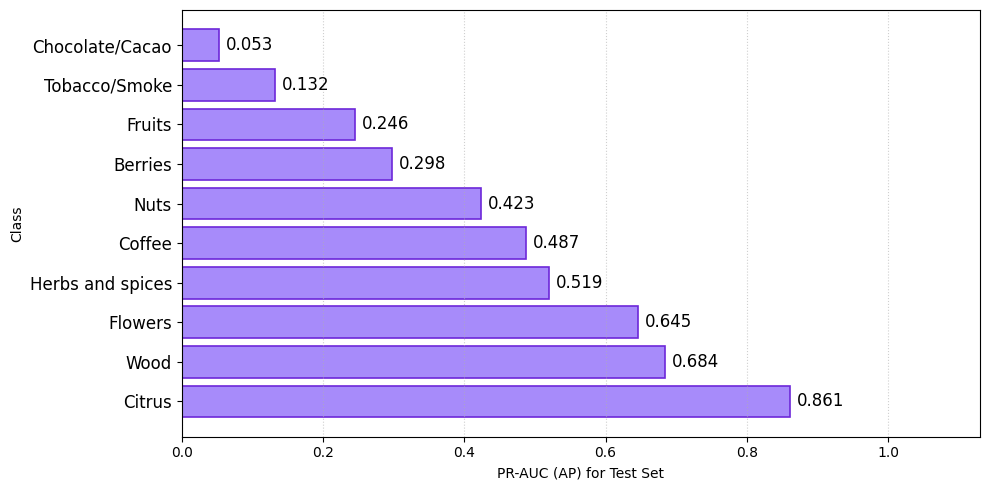

In [26]:
def plot_pr_auc_test(ap_values, class_names, y_test_tensor, savepath=None, show_lift=True):

    ap_values = np.asarray(ap_values, dtype=float)
    if hasattr(y_test_tensor, "cpu"):
        Yt = y_test_tensor.cpu().numpy()
    else:
        Yt = np.asarray(y_test_tensor)

    # Prevalence 
    prev = np.nanmean(Yt, axis=0).astype(float)

    ap_safe = np.copy(ap_values)
    ap_sort_key = np.where(np.isnan(ap_safe), -1.0, ap_safe)

    order = np.argsort(-ap_sort_key)
    ap_sorted   = ap_values[order]
    prev_sorted = prev[order]
    names_sorted = [class_names[i] for i in order]

    y_pos = np.arange(len(ap_sorted))

    fig, ax = plt.subplots(figsize=(10, max(4, 0.5 * len(ap_sorted))))

    bars = ax.barh(y_pos, np.nan_to_num(ap_sorted, nan=0.0),
                   color="#a78bfa", edgecolor="#6d28d9", lw=1.2)
    ax.set_xlim(0, 1.13)
    ax.set_xlabel("PR-AUC (AP) for Test Set", fontsize=10)
    ax.set_ylabel("Class")
    ax.set_yticks(y_pos)
    ax.set_yticklabels(names_sorted, fontsize=12)
    ax.grid(axis="x", linestyle=":", alpha=0.6)

    for bar, apv, pv in zip(bars, ap_sorted, prev_sorted):
        y = bar.get_y() + bar.get_height() / 2
        x_text = min((0.0 if np.isnan(apv) else apv) + 0.01, 0.98)
        label = f"{apv:.3f}"
        if show_lift:
            ax.text(x_text, y, label, va="center", fontsize=12)

    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=300)
    plt.show()

plot_pr_auc_test(test_ap, class_names, y_test, savepath=None, show_lift=True)